In [1]:
!pip uninstall echogains -y
!pip install ../

Found existing installation: echogains 0.1.1
Uninstalling echogains-0.1.1:
  Successfully uninstalled echogains-0.1.1
Processing /home/gillesv/PycharmProjects/EchoGAINS
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for echogains: filename=echogains-0.1.1-py3-none-any.whl size=113849 sha256=2d6eadbe58669bd6893385c724a9de4b4203fc5e7a0ca3a72e29f59e7f9e0f36
  Stored in directory: /tmp/pip-ephem-wheel-cache-4qye5_gv/wheels/a6/bc/34/8c8c147aeb8c860efbc65ab7c19eb89d1ca43281064c5db452
Successfully built echogains


In [2]:
# Some additional libraries for the tutorial
!pip install matplotlib

In [3]:
# Donwload a small sample of test data
# This will download +-240Mb of data under ./local__data/sample_data
import os
import echogains
current_directory = os.getcwd()
download_loc = os.path.join(current_directory,"local_data")
echogains.download_data_sample(download_loc,verbose=True)

Fetching contents from: https://api.github.com/repos/GillesVanDeVyver/us_cardiac_sample_data/contents/sample_data
Fetching contents from: https://api.github.com/repos/GillesVanDeVyver/us_cardiac_sample_data/contents/sample_data_seg


 17%|███████▌                                     | 1/6 [00:00<00:01,  2.62it/s]

Downloaded: /home/gillesv/PycharmProjects/EchoGAINS/tutorial/local_data/sample_data/a2c.mp4


 33%|███████████████                              | 2/6 [00:05<00:13,  3.31s/it]

Downloaded: /home/gillesv/PycharmProjects/EchoGAINS/tutorial/local_data/sample_data/a2c.npy


 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.95s/it]

Downloaded: /home/gillesv/PycharmProjects/EchoGAINS/tutorial/local_data/sample_data/a4c.mp4


 67%|██████████████████████████████               | 4/6 [00:09<00:05,  2.67s/it]

Downloaded: /home/gillesv/PycharmProjects/EchoGAINS/tutorial/local_data/sample_data/a4c.npy


 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.83s/it]

Downloaded: /home/gillesv/PycharmProjects/EchoGAINS/tutorial/local_data/sample_data/alax.mp4


100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.39s/it]

Downloaded: /home/gillesv/PycharmProjects/EchoGAINS/tutorial/local_data/sample_data/alax.npy



 33%|███████████████                              | 1/3 [00:00<00:01,  1.38it/s]

Downloaded: /home/gillesv/PycharmProjects/EchoGAINS/tutorial/local_data/sample_data_seg/a2c.npy


 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.30it/s]

Downloaded: /home/gillesv/PycharmProjects/EchoGAINS/tutorial/local_data/sample_data_seg/a4c.npy


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.32it/s]

Downloaded: /home/gillesv/PycharmProjects/EchoGAINS/tutorial/local_data/sample_data_seg/alax.npy


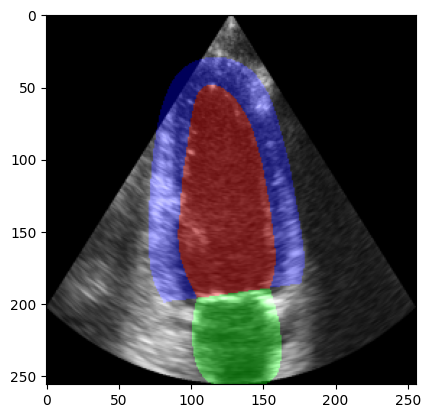

In [4]:
# Load a sample
import os
import numpy as np
import matplotlib.pyplot as plt
sample_a2c = np.load(os.path.join(download_loc,"sample_data/a2c.npy"))
# sample_a2c is an ndarray of shape (nb_frames,height,width) with values in range [0,255]
sample_frame = sample_a2c[-1]
sample_a2c_seg = np.load(os.path.join(download_loc,"sample_data_seg/a2c.npy"),allow_pickle=True)
# sample_a2c_seg is an ndarray of shape (nb_frames,height,width) with values in range [0,4]
# 0: background, 1: left ventricle, 2: myocardium, 3: left atrium
frame_seg = sample_a2c_seg[-1]
visual = echogains.create_visualization(sample_frame,frame_seg)
plt.imshow(visual)
plt.show()

In [5]:
'''
# EchoGAINS works with datasets that have the following structure:
├── images
│   ├── frame1.png
│   ├── frame2.png
│   ├── ...
├── labels
│   ├── frame1.png
│   ├── frame2.png
│   ├── ...
The images folder should contain the bmode images as grayscale pngs.
The labels folder should contains the labels with the following convention:
0: background, 1: left ventricle, 2: myocardium, 3: left atrium

Let's create a simple dataset of a few frames in this format from the sample data we downloaded.
'''
import os
import numpy as np
from PIL import Image
from skimage.transform import resize
from tqdm import tqdm

## some helper functions
def save_as_image(np_array,path):
    """
    Save a 2D numpy array as a grayscale image (only 1 channel)
    :param np_array: np.array of size (W,H)
        The array to save
    :param path: str
        The path to sae the array to
    """
    img_data = Image.fromarray(np_array)
    img_data = img_data.convert("L")
    img_data.save(path)

def create_dataset(sample_frames, sample_segments, output_dir, num_frames=5):
    """
    Create a dataset from the given sample frames and segments.
    The function will select num_frames random frames from the sample frames and save them to the output_dir.
    :param sample_frames: np.array of shape (nb_frames, height, width)
        The sample frames
    :param sample_segments: np.array of shape (nb_frames, height, width)
        The sample segments
    :param output_dir: str
        The output directory to save the dataset to
    :param num_frames: int
        The number of frames to save
    """
    nb_frames = sample_frames.shape[0]
    assert nb_frames == sample_segments.shape[0], "Number of frames in sample_frames and sample_segments should be equal."
    image_dir = os.path.join(output_dir, "images")
    label_dir = os.path.join(output_dir, "labels")
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i in tqdm(range(num_frames)):
        # sample a ramdom frame
        idx = np.random.randint(nb_frames)
        frame = sample_frames[idx]
        seg = sample_segments[idx]

        # save frame
        frame_path = os.path.join(image_dir, f"frame{i}.png")
        save_as_image(frame, frame_path)

        # save segmentation
        seg_path = os.path.join(label_dir, f"frame{i}.png")
        save_as_image(seg, seg_path)

# Define output dataset path
custom_dataset_path = os.path.join(download_loc, "custom_dataset")
label_path=os.path.join(custom_dataset_path, "labels")
images_path = os.path.join(custom_dataset_path, "images")

# resize sample_a2c to (256,256)
sample_a2c = resize(sample_a2c, (sample_a2c.shape[0], 256, 256), preserve_range=True)
# Create dataset
nb_frames=5
create_dataset(sample_a2c, sample_a2c_seg, custom_dataset_path, num_frames=nb_frames)

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 391.16it/s]


In [6]:

'''
Now we prepare the custom dataset for generative augmentation.
The script below creates the following structure inside the download_loc folder:
├── custom_dataset_augmented
│   ├── images
│   │   ├── frame0.png
│   │   ├── frame1.png
│   │   ├── ...
│   ├── labels
│   │   ├── frame0.png
│   │   ├── frame0_aug0.png
│   │   ├── frame0_aug1.png
│   │   ├── ...
│   │   ├── frame1.png
│   │   ├── frame1_aug0.png
│   │   ├── ...
│   ├── repaint
│   │   ├── keep
│   │   │   ├── frame0.png
│   │   │   ├── frame1.png
│   │   │   ├── ...
│   │   ├── masks
│   │   │   ├── frame0.png
│   │   │   ├── frame1.png
│   │   │   ├── ...
The keep folder in repaint contains the transformed images with the pixels that are kept.
The masks folder in repaint contains the masks of the transformed images. This tells repaint which pixels to keep.
'''
repaint_keep_path = os.path.join(download_loc, "repaint", "keep")
repaint_masks_path = os.path.join(download_loc, "repaint", "masks")
augmented_dataset_path = os.path.join(download_loc, "custom_dataset_augmented")

augmentation_params= [
    {'type': 'depth', 'prob': 0.5, 'depth_increase_range': [0,150] }, # increase depth by 0 to 150 pixels
    {'type': 'rotation', 'prob': 0.5, 'rotation_range': [-30, 30]}, # rotate image by -30 to 30 degrees
    {'type': 'sector_width', 'prob': 0.5, 'width_factor': [0.5, 1.5]}, # change sector width by factor 0,5 to 1.5
    {'type': 'translation', 'prob': 0.5, 'displacement_radius_range': [0, 50]} # translate image by a distance between 0 to 50 pixels in a random direction
] # all augmentations are applied with a probability of 50%
nb_augmentations = 5 # create 5 augmented images for each original image in the dataset

echogains.prepare_gen_aug_seg(custom_dataset_path,
                            augmented_dataset_path,
                            repaint_keep_path,
                            repaint_masks_path,
                            augmentation_params,
                            nb_augmentations,
                            include_original=True)

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.15it/s]


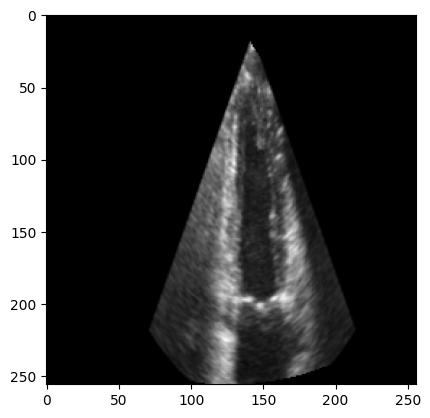

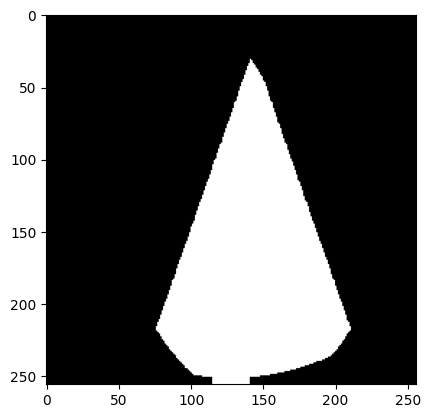

In [7]:
# let's plot a sample from the repaint/keep and repaint/masks folders to illustrate
import matplotlib.pyplot as plt
import os

# Load a png from repaint/keep. This is the transformed image with the pixels that are kept.
sample_keep = plt.imread(os.path.join(repaint_keep_path, "frame0_aug0.png"))
plt.imshow(sample_keep, cmap='gray')
plt.show()

# Load a png from repaint/masks. This is the mask of the transformed image. This tells repaint which pixels to keep
# and which to repaint.
sample_mask = plt.imread(os.path.join(repaint_masks_path, "frame0_aug0.png"))
plt.imshow(sample_mask, cmap='gray')
plt.show()

# the generative model will repaint everything that falls outside the mask in the transformed image

In [8]:
# Now we run RePaint inference
# First, we need to download a nodel trained on CAMUS from HuggingFace
echogains.download_and_set_up_model('CAMUS_diffusion_model')

# buffer_path is the directory used for temporary storage during inference
buffer_path = os.path.join(download_loc, "repaint", "buffer")
nb_files_in_dataset = nb_frames * nb_augmentations
aug_output_path=os.path.join(augmented_dataset_path, "images")

# Now we run RePaint inference
config = echogains.load_default_config('CAMUS_diffusion_model',repaint_keep_path,repaint_masks_path,
                                       buffer_path,images_path)

echogains.run_repaint(config)


Download link for model CAMUS_diffusion_model is ('gillesvdv/CAMUS_diffusion_model', 'CAMUS_diffusion_model.pt')
Model downloaded to /home/gillesv/miniconda3/lib/python3.11/site-packages/echogains/models/models--gillesvdv--CAMUS_diffusion_model/snapshots/42be9f6b7ace0a56408c7c52a57342cf7e28a8a8/CAMUS_diffusion_model.pt
Copied /home/gillesv/miniconda3/lib/python3.11/site-packages/echogains/models/models--gillesvdv--CAMUS_diffusion_model/snapshots/42be9f6b7ace0a56408c7c52a57342cf7e28a8a8/CAMUS_diffusion_model.pt to /home/gillesv/miniconda3/lib/python3.11/site-packages/echogains/models
Model CAMUS_diffusion_model.pt set up successfully!
Start camus_all
Total number of parameters in model: 41125062
sampling...
batch: 0


  0%|          | 0/4570 [00:00<?, ?it/s]

sampling complete


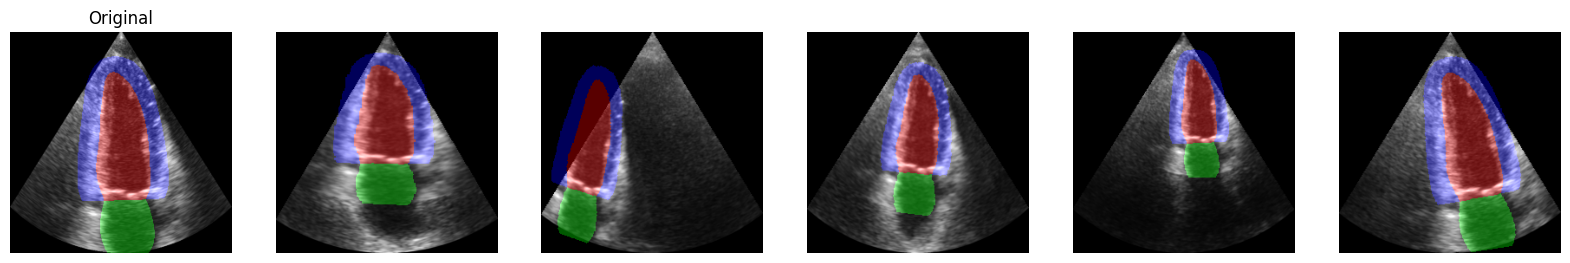

In [15]:

# Let's visualize a sample of the dataset and it's augmentations

fig, axs = plt.subplots(1, nb_augmentations+1, figsize=(20, 10))

original_sample = 'frame4'

# Load the original image
original_img = plt.imread(os.path.join(images_path, f"{original_sample}.png"))
original_label = plt.imread(os.path.join(label_path, f"{original_sample}.png"))
original_label=(256*original_label).astype(np.uint8)

original_visual = echogains.create_visualization(original_img, original_label)


axs[0].imshow(original_visual)
axs[0].set_title("Original")



# Load the augmented images
for i in range(nb_augmentations):
    augmented_img = plt.imread(os.path.join(augmented_dataset_path, "images", f"{original_sample}_aug{i}.png"))
    augmented_img=augmented_img[:,:,0] # rgb to grayscale
    augmented_label = plt.imread(os.path.join(augmented_dataset_path, "labels", f"{original_sample}_aug{i}.png"))
    augmented_label=(256*augmented_label).astype(np.uint8)
    augmented_visual = echogains.create_visualization(augmented_img, augmented_label)
    axs[i+1].imshow(augmented_visual)


# remove axis
for ax in axs:
    ax.axis('off')
plt.show()